In [1]:
import os
os.chdir("..")

<h3> Load Libraries </h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.metrics import get_error_stats
from production.plots import plot_adaptive_evolution

<h3> Preprocess data </h3>

In [3]:
watershed_name = "Duwamish"

In [ ]:
watershed = Preprocessor(config_path = f"/workspaces/Importance-Sampling-for-SST/data/0_source/{watershed_name}/config.json", 
                       output_folder = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}")
watershed.run()

In [4]:
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")

<h3> Full Monte Samples </h3>

In [5]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=20_000,
    num_rep=50,
)

fullmonte_samples = sampler.sample(data = watershed)

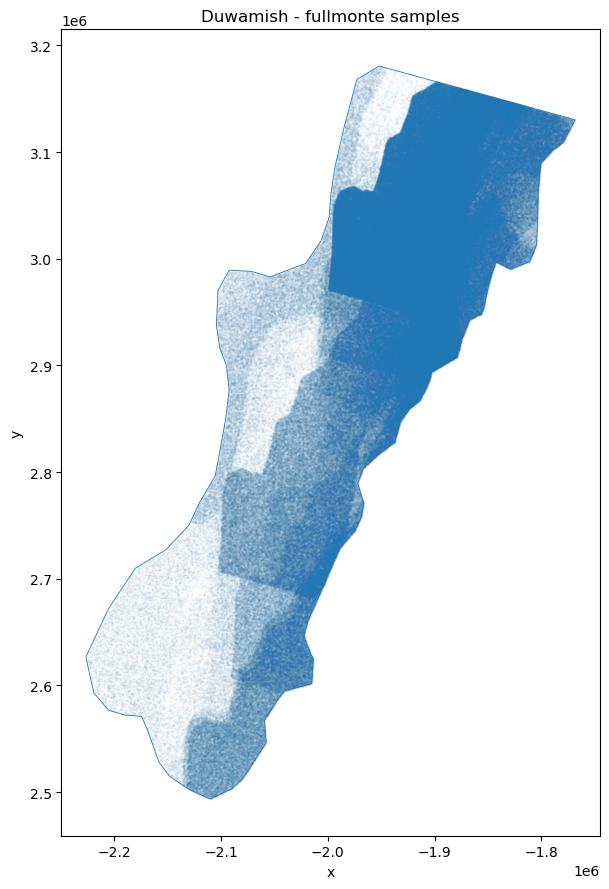

In [6]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(fullmonte_samples.newx, fullmonte_samples.newy, s=0.2, alpha=0.05, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - fullmonte samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [7]:
fullmonte_depths = StormDepthProcessor(watershed).run(fullmonte_samples, n_jobs=-1)

In [9]:
# Sort within each rep and compute return period
df_sorted = (
   fullmonte_depths
   .sort_values(["rep", "precip_avg_mm"], ascending=[True, False])
   .reset_index(drop=True)
   .copy()
)
# Compute return_period within each rep group
df_sorted["return_period"] = (
   df_sorted
   .groupby("rep", group_keys=False)
   .apply(lambda g: 1 / (1 - np.exp(-10 * g["exc_prb"])))
)
df_sorted["precip_avg_mm"] = df_sorted["precip_avg_mm"]/25.4

/tmp/ipykernel_10113/4028364102.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: 1 / (1 - np.exp(-10 * g["exc_prb"])))


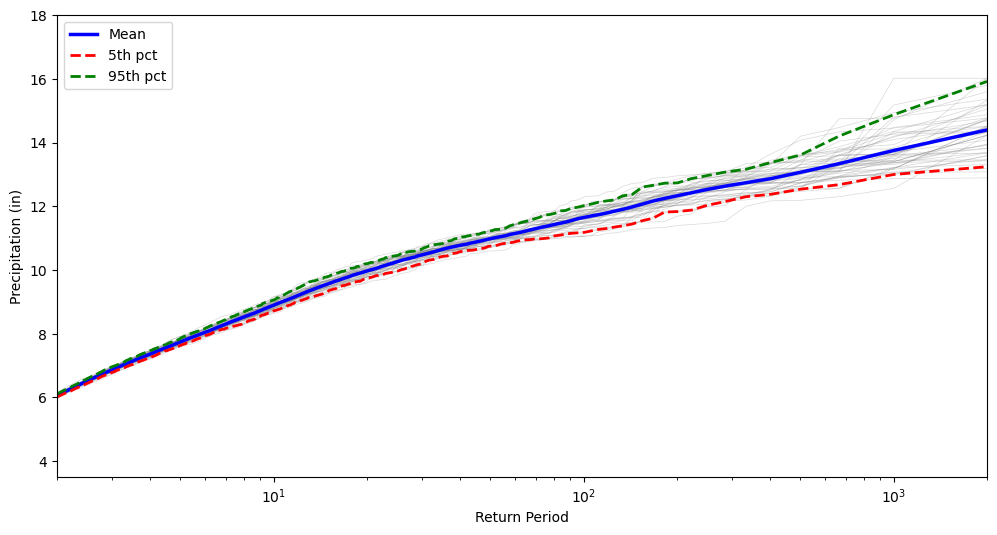

In [13]:
# assumes df_sorted has columns: rep, return_period, precip_avg_mm
fig, ax = plt.subplots(figsize=(12,6))
# plot each rep as a thin line
for rep, g in df_sorted.groupby("rep"):
   ax.plot(g["return_period"], g["precip_avg_mm"],
           color='gray', alpha=0.3, linewidth=0.5)
# compute mean, 5th, 95th across reps for each return_period
summary = (
   df_sorted.groupby("return_period")["precip_avg_mm"]
   .agg(mean='mean', p5=lambda x: np.percentile(x,5),
        p95=lambda x: np.percentile(x,95))
   .reset_index()
)
# plot mean as thick solid line
ax.plot(summary["return_period"], summary["mean"],
       color='blue', linewidth=2.5, label='Mean')
# plot 5th and 95th as dashed thick lines
ax.plot(summary["return_period"], summary["p5"],
       color='red', linewidth=2, linestyle='--', label='5th pct')
ax.plot(summary["return_period"], summary["p95"],
       color='green', linewidth=2, linestyle='--', label='95th pct')
ax.set_xlabel('Return Period')
ax.set_xscale('log') 
ax.set_xlim(2, 2000)
ax.set_ylim(3.5, 18)
ax.set_ylabel('Precipitation (in)')
ax.legend()
plt.show()

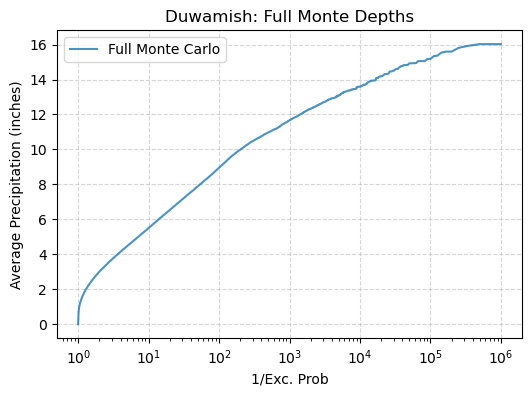

In [8]:
df_sorted = fullmonte_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))
plt.plot(
    1 / df_sorted["exc_prb"],  
    df_sorted["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")  # updated units
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Full Monte Depths")
plt.show()

In [14]:
#Save
fullmonte_depths.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

In [10]:
#Read
fullmonte_depths = pd.read_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

<h3> Importance Sampling - Truncated Normals </h3>

In [34]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*1.5,
    "sd_y": watershed.watershed_stats["range_y"]*2,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

TruncNorm_samples = sampler.sample(data = watershed)

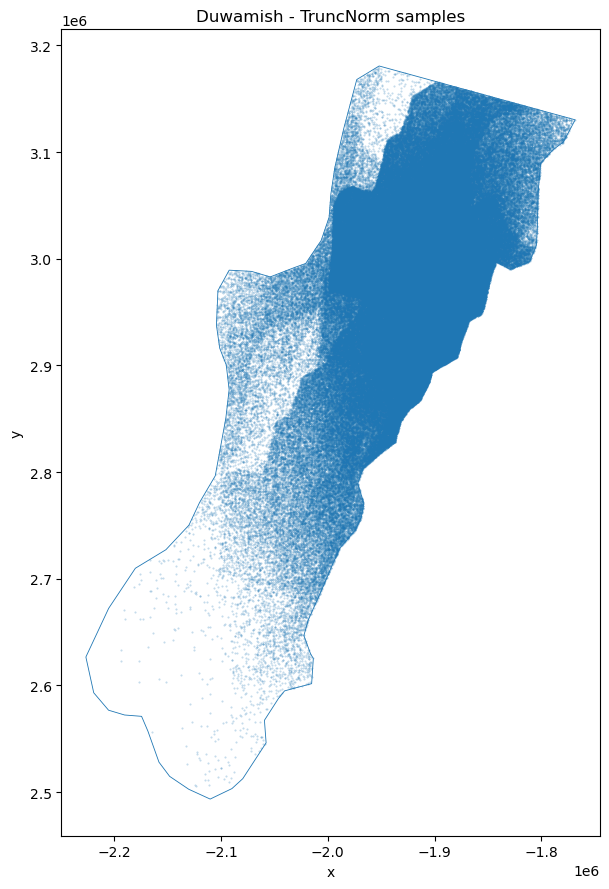

In [35]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(TruncNorm_samples.newx, TruncNorm_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - TruncNorm samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [36]:
TruncNorm_depths = StormDepthProcessor(watershed).run(TruncNorm_samples, n_jobs=-1)

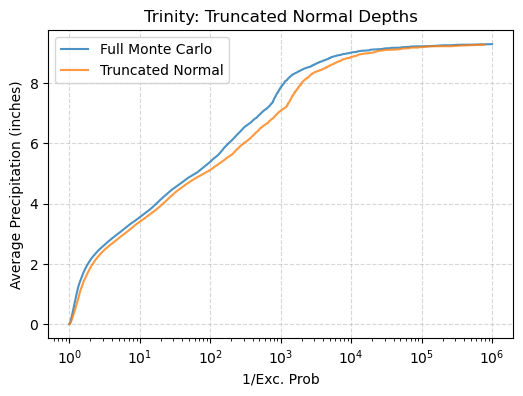

In [38]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Truncated Normal"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Truncated Normal Depths")
plt.show()

<h3> Importance Sampling - Gaussian Copula </h3>

In [42]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

copula_samples = sampler.sample(data = watershed)

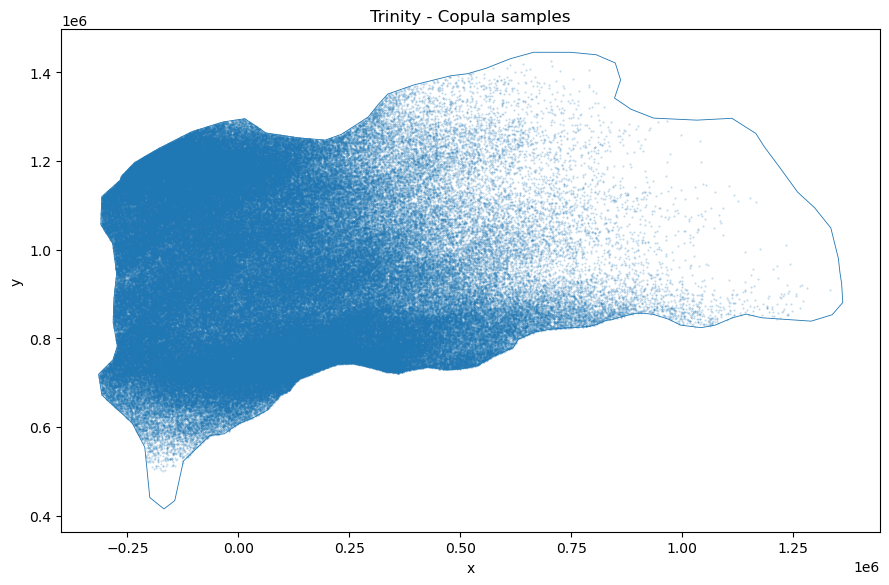

In [45]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [47]:
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

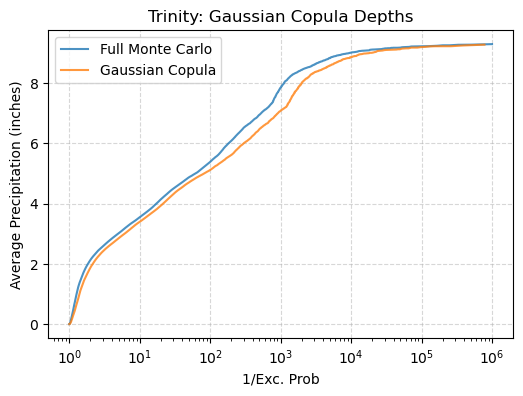

In [48]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Gaussian Copula"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Gaussian Copula Depths")
plt.show()

<h3> Importance Sampling - Mixture</h3>

In [24]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.5,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.5,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.6,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=200_000,
    num_rep=1,
    seed=42,
)

mixture_samples = sampler.sample(data = watershed)

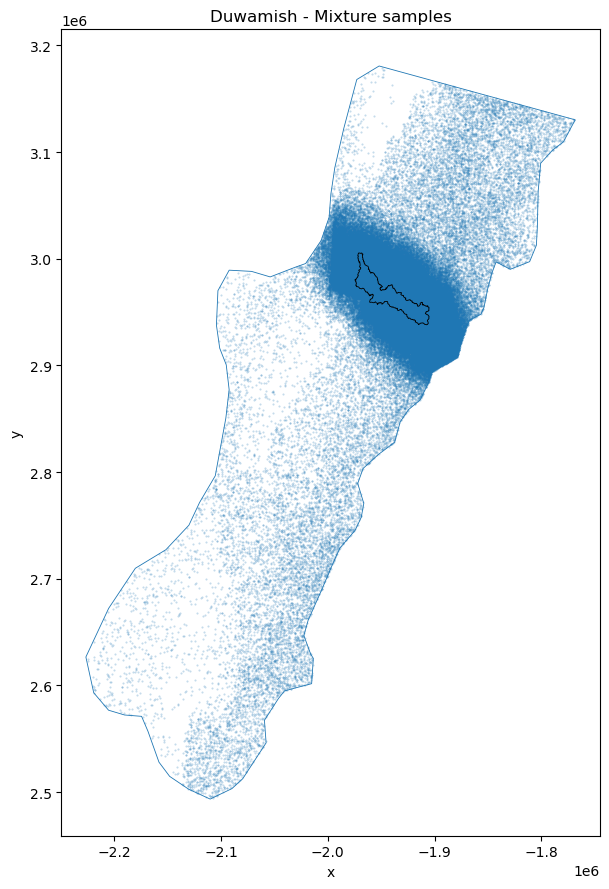

In [25]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.boundary.plot(ax=ax, linewidth=0.6, color="black")
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Mixture samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [26]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

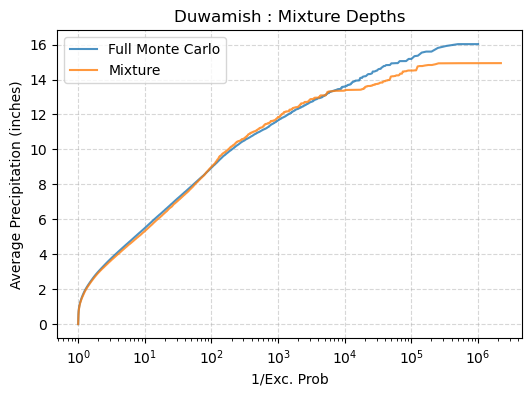

In [27]:
import matplotlib.pyplot as plt

# Sort both datasets by exceedance probability
df_full = fullmonte_depths.sort_values("exc_prb")
df_mixture = mixture_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))

# Full Monte Carlo
plt.plot(
    1 / df_full["exc_prb"], 
    df_full["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

# Truncated Normal
plt.plot(
    1 / df_mixture["exc_prb"], 
    df_mixture["precip_avg_mm"] / 25.4,
    label="Mixture",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name} : Mixture Depths") 
plt.show() 

<h3> Importance Sampling - Adaptive Mixture </h3>

In [ ]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"]*0.5,
    sd_y_n=watershed.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=watershed.cumulative_precip,
    storm_centers=watershed.storm_centers,
    watershed_gdf=watershed.watershed_gdf,
    domain_gdf=watershed.domain_gdf,
    params=params,
    seed=42,
)

In [ ]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

In [ ]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
#Do final N required samples from the final distributions
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 